## Computer Vision Assignment: Histogram Matching
Phạm Đức Duy - MSSV: 23001855

In [1]:
import cv2
import numpy as np
import skimage
import PIL

# Libaries
print(f"OpenCV Version: {cv2.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Scikit-Image Version: {skimage.__version__}")
print(f"Pillow Version: {PIL.__version__}")

OpenCV Version: 4.8.0
NumPy Version: 1.24.4
Scikit-Image Version: 0.21.0
Pillow Version: 9.5.0


In [2]:
import os

data_dir = "data/"
image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

print("Images availible in directory data/:")
for img in image_files:
    print(img)

Images availible in directory data/:
cat.jpg
landsat_day.jpg
landsat_night.jpg
landscape.jpg
mono_landscape.jpg
mri_brain.jpg
tir_cat.jpg
xray_chest.jpg


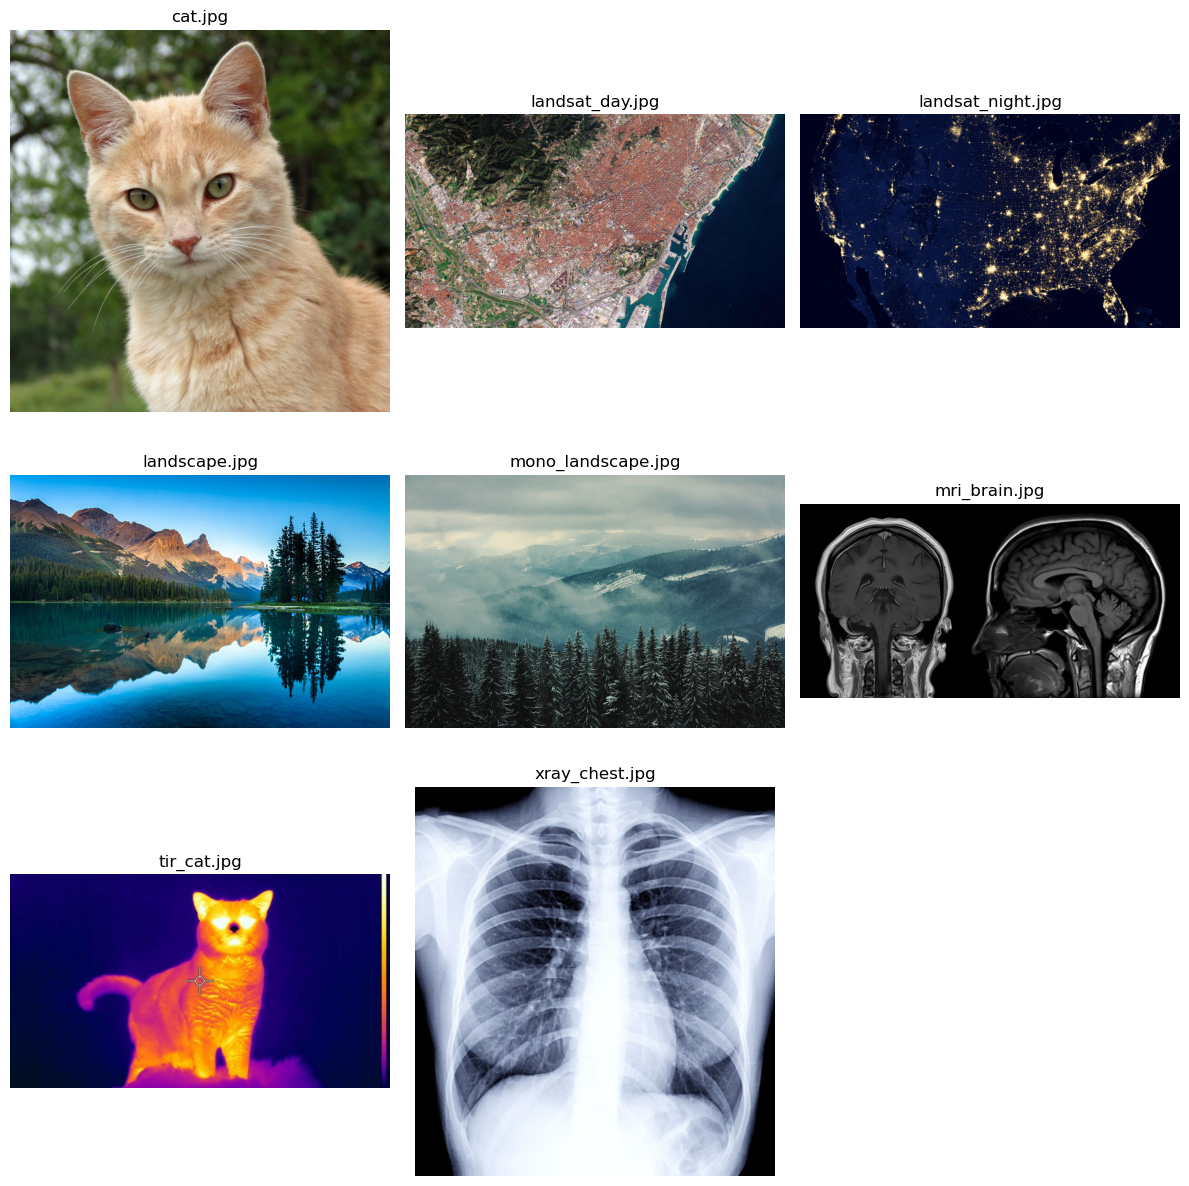

In [3]:
import matplotlib.pyplot as plt
import cv2

cols = min(3, len(image_files))  
rows = (len(image_files) + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

axes = axes if rows > 1 else [axes]

for idx, img_name in enumerate(image_files):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    ax = axes[idx // cols][idx % cols]  
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis("off")

for i in range(len(image_files), rows * cols):
    axes[i // cols][i % cols].axis("off")

plt.tight_layout()
plt.show()

- The histogram $ H(I) $ of an image $ I $ is defined as:

$$
H(I,k) = \sum_{x, y} \delta(I(x,y)=k)
$$

where $ k $ represents the grayscale level or the color value in a specific channel.

- The cumulative distribution function (CDF) is given by:

$$
\text{CDF}(k) = \sum^k_{i=0} H(I,i)
$$

To determine the new pixel values in $ I^{'}(x,y) $, we map them using the CDF of the reference image.

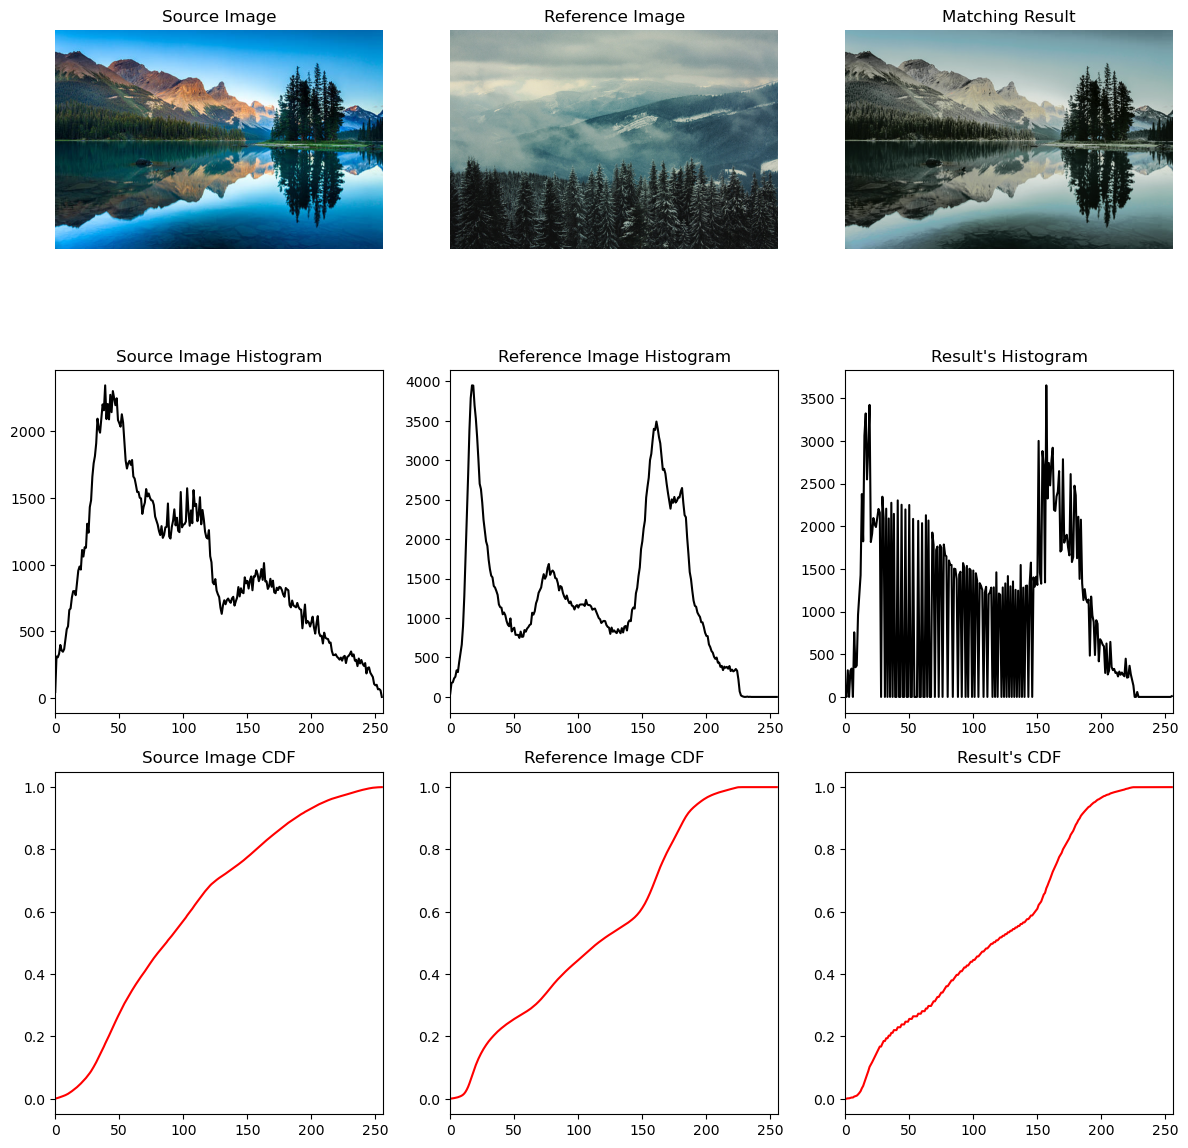

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_cdf(hist):
    return hist.cumsum() / hist.sum()

def match_histogram(source, reference):
    matched = np.zeros_like(source)
    
    for channel in range(source.shape[2]):
        hist_src, bins = np.histogram(source[..., channel], bins=256, range=(0, 256))
        hist_ref, _ = np.histogram(reference[..., channel], bins=256, range=(0, 256))
        
        cdf_src = calculate_cdf(hist_src)
        cdf_ref = calculate_cdf(hist_ref)
        
        mapping = np.interp(cdf_src, cdf_ref, np.arange(256))
        matched[..., channel] = np.round(mapping[source[..., channel]]).astype(np.uint8)
    
    return matched

def plot_results(src_img, ref_img, matched_img):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    axes[0, 0].imshow(cv2.cvtColor(src_img, cv2.COLOR_YCrCb2RGB))
    axes[0, 0].set_title("Source Image")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cv2.cvtColor(ref_img, cv2.COLOR_YCrCb2RGB))
    axes[0, 1].set_title("Reference Image")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(cv2.cvtColor(matched_img, cv2.COLOR_YCrCb2RGB))
    axes[0, 2].set_title("Matching Result")
    axes[0, 2].axis("off")

    for i, img in enumerate([src_img[..., 0], ref_img[..., 0], matched_img[..., 0]]):
        hist, bins = np.histogram(img.flatten(), 256, [0,256])
        axes[1, i].plot(hist, color='black')
        axes[1, i].set_title(["Source Image Histogram", "Reference Image Histogram", "Result's Histogram"][i])
        axes[1, i].set_xlim([0, 256])

    for i, img in enumerate([src_img[..., 0], ref_img[..., 0], matched_img[..., 0]]):
        hist, _ = np.histogram(img.flatten(), 256, [0, 256])
        cdf = calculate_cdf(hist)
        axes[2, i].plot(cdf, color='red')
        axes[2, i].set_title(["Source Image CDF", "Reference Image CDF", "Result's CDF"][i])
        axes[2, i].set_xlim([0, 256])

    plt.tight_layout()
    plt.show()

data_dir = "data/"
land_hismatch = cv2.imread(data_dir + "landscape.jpg")
monoland_hismatch = cv2.imread(data_dir + "mono_landscape.jpg")

land_hismatch = cv2.cvtColor(land_hismatch, cv2.COLOR_BGR2YCrCb)
monoland_hismatch = cv2.cvtColor(monoland_hismatch, cv2.COLOR_BGR2YCrCb)

matched_landscape = match_histogram(land_hismatch, monoland_hismatch)
plot_results(land_hismatch, monoland_hismatch, matched_landscape)

## Histogram Matching for Color Images

### Color Space Conversion
- The image is converted from BGR to **YCrCb** to separate luminance (Y) from color information (Cr, Cb).
- Matching is performed only on the **Y** channel to avoid distorting overall colors.

### Computing Histogram and CDF
- The histogram for each channel is computed using `np.histogram()`.
- The CDF (Cumulative Distribution Function) is calculated with `hist.cumsum() / hist.sum()` for normalization.

### Histogram Mapping
- The CDF of the source image is mapped to the CDF of the reference image using `np.interp()`.
- Each pixel intensity value in the source image is replaced with the closest corresponding value from the reference image.

### Displaying Results
- Compare the source image, reference image, and the transformed image.
- Display the histogram of the **Y** channel before and after matching.

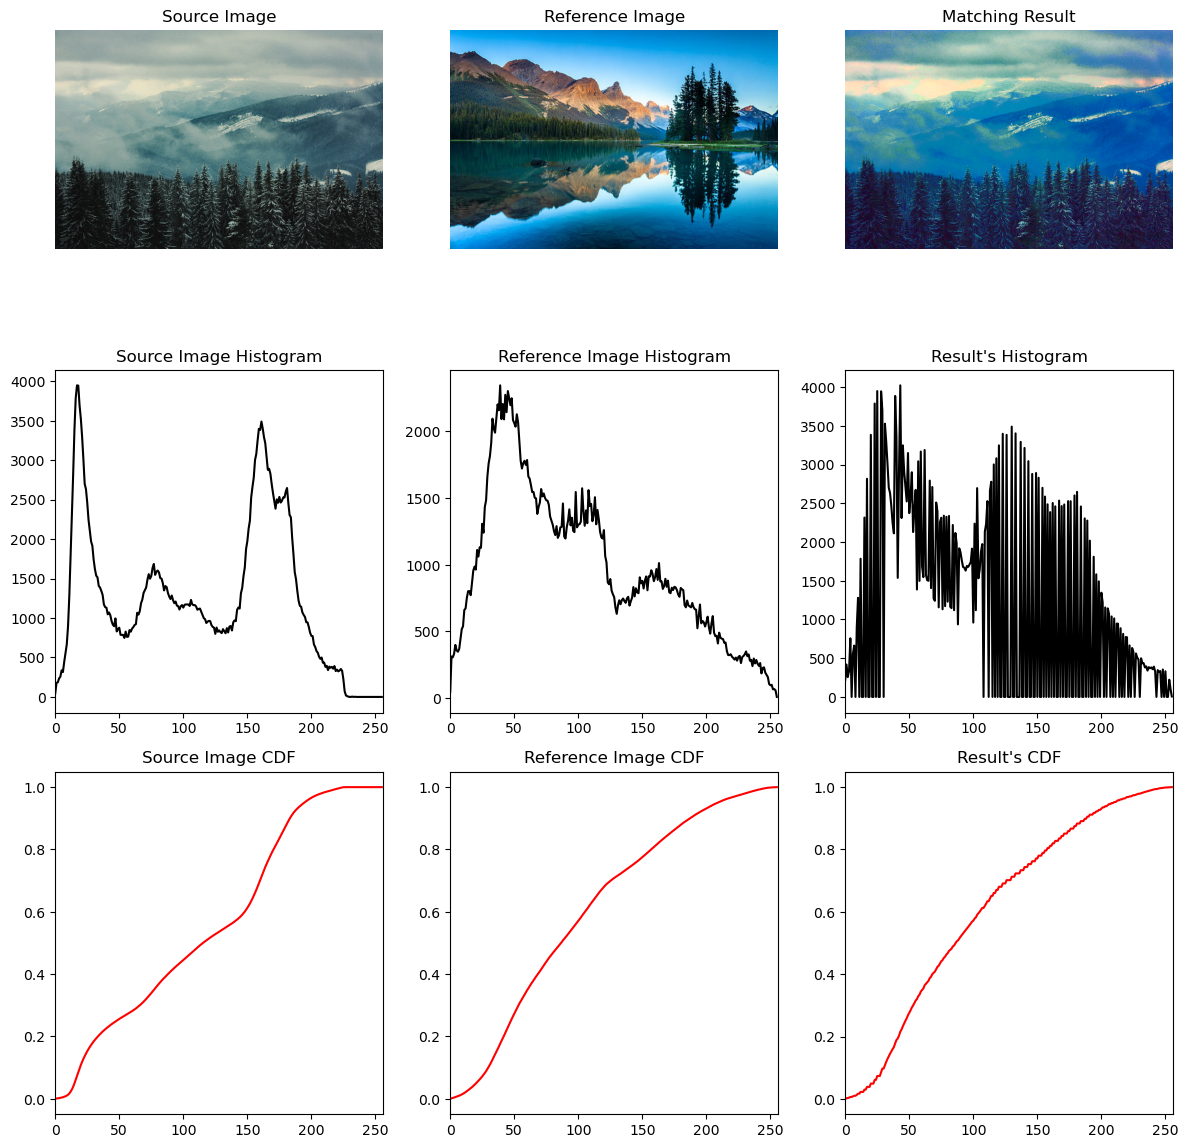

In [5]:
matched_landscape_rev = match_histogram(monoland_hismatch, land_hismatch)
plot_results(monoland_hismatch, land_hismatch, matched_landscape_rev)

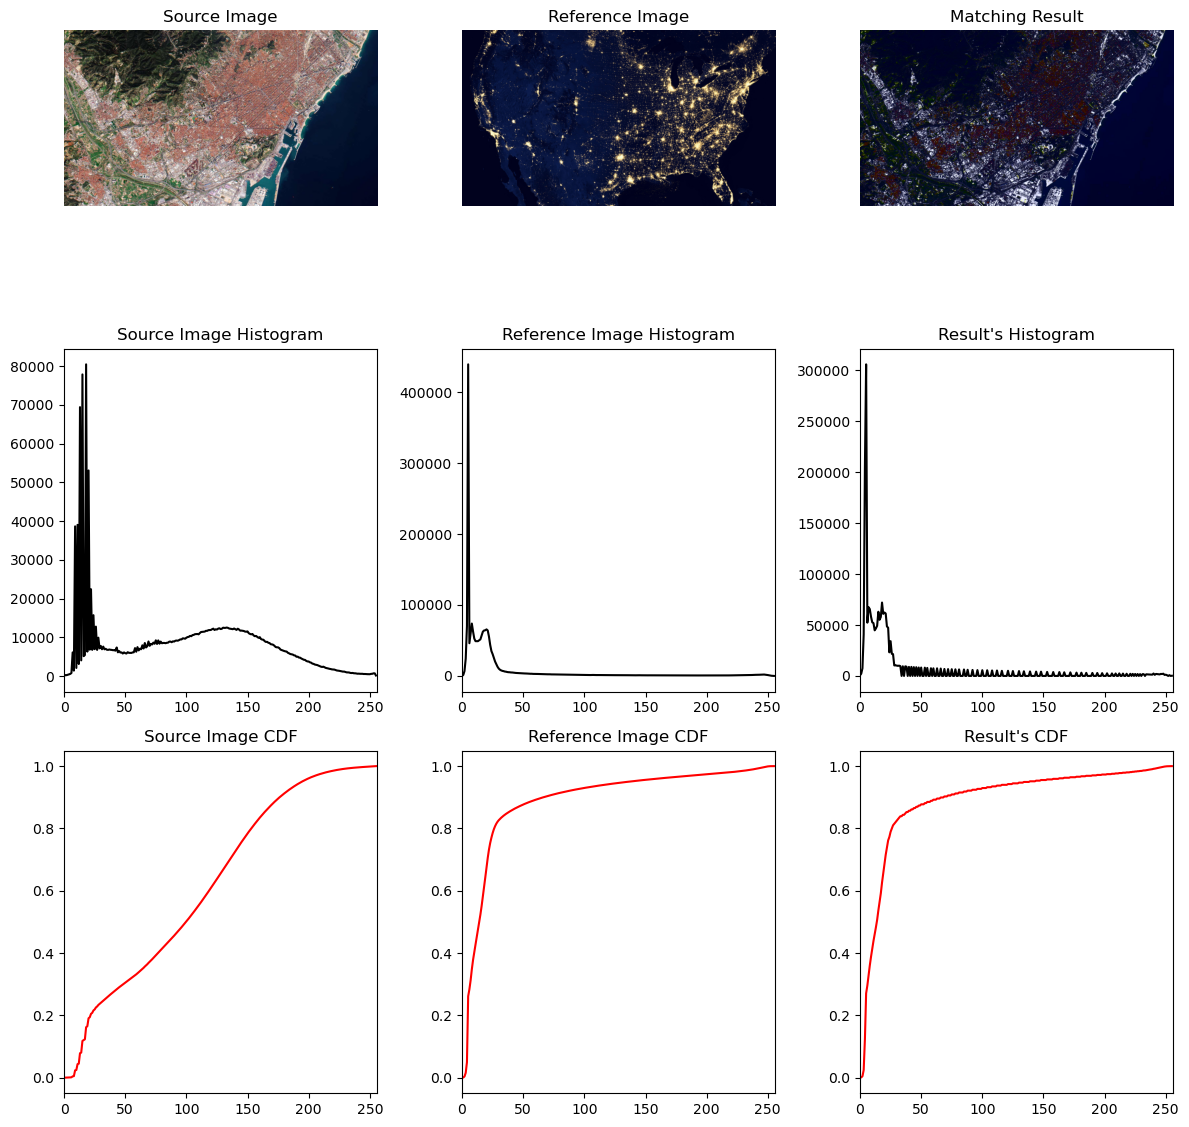

In [6]:
landsatday_hismatch = cv2.imread(data_dir + "landsat_day.jpg")
landsatnight_hismatch = cv2.imread(data_dir + "landsat_night.jpg")

landsatday_hismatch = cv2.cvtColor(landsatday_hismatch, cv2.COLOR_BGR2YCrCb)
landsatnight_hismatch = cv2.cvtColor(landsatnight_hismatch, cv2.COLOR_BGR2YCrCb)

matched_landsat = match_histogram(landsatday_hismatch, landsatnight_hismatch)
plot_results(landsatday_hismatch, landsatnight_hismatch, matched_landsat)

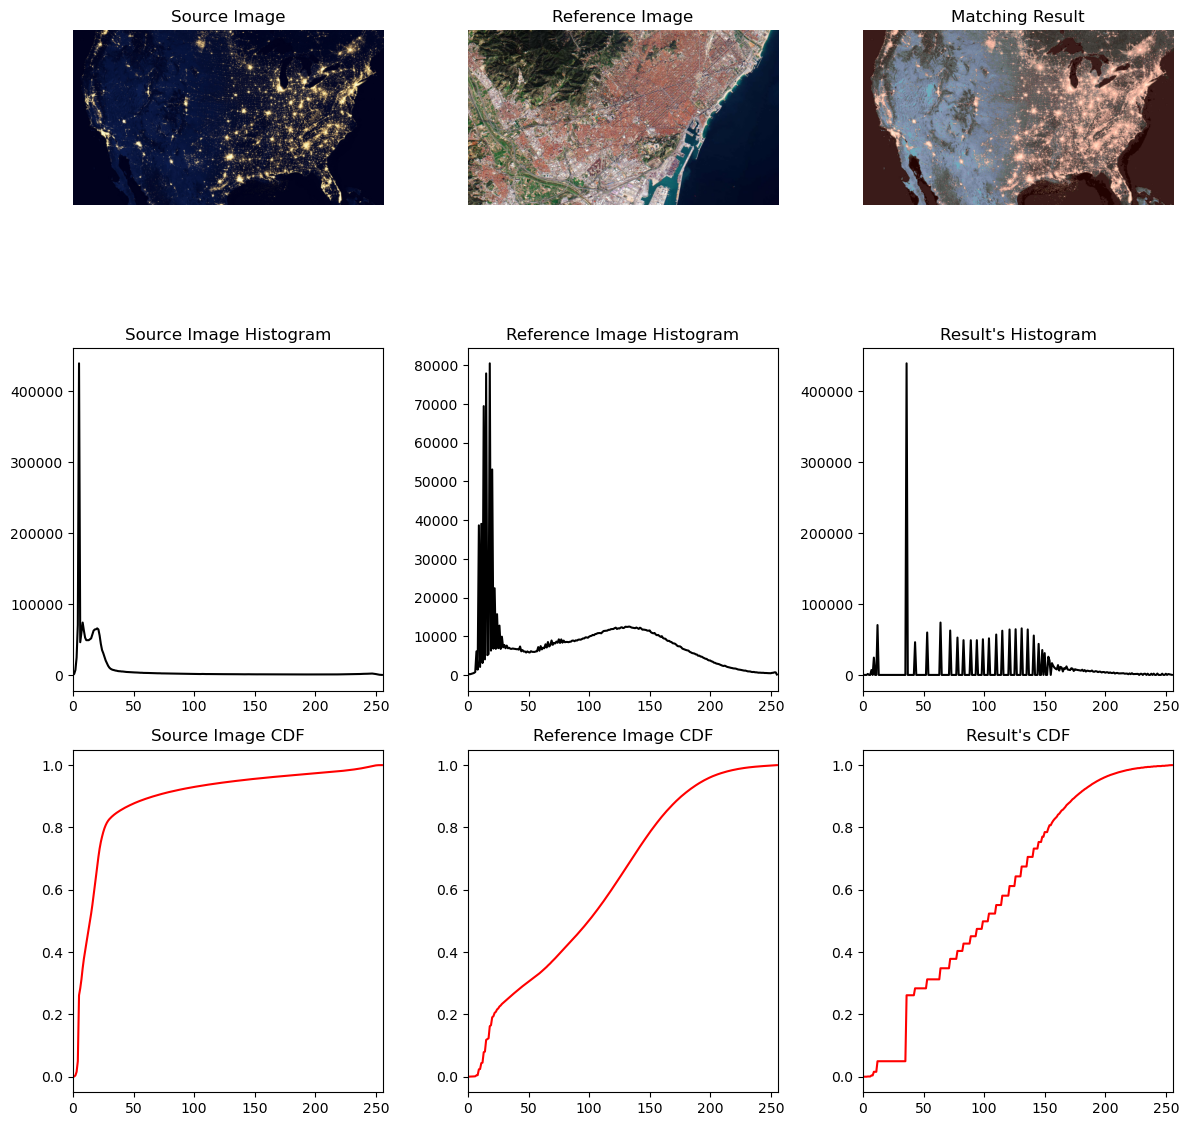

In [7]:
matched_landsat_rev = match_histogram(landsatnight_hismatch, landsatday_hismatch)
plot_results(landsatnight_hismatch, landsatday_hismatch, matched_landsat_rev)

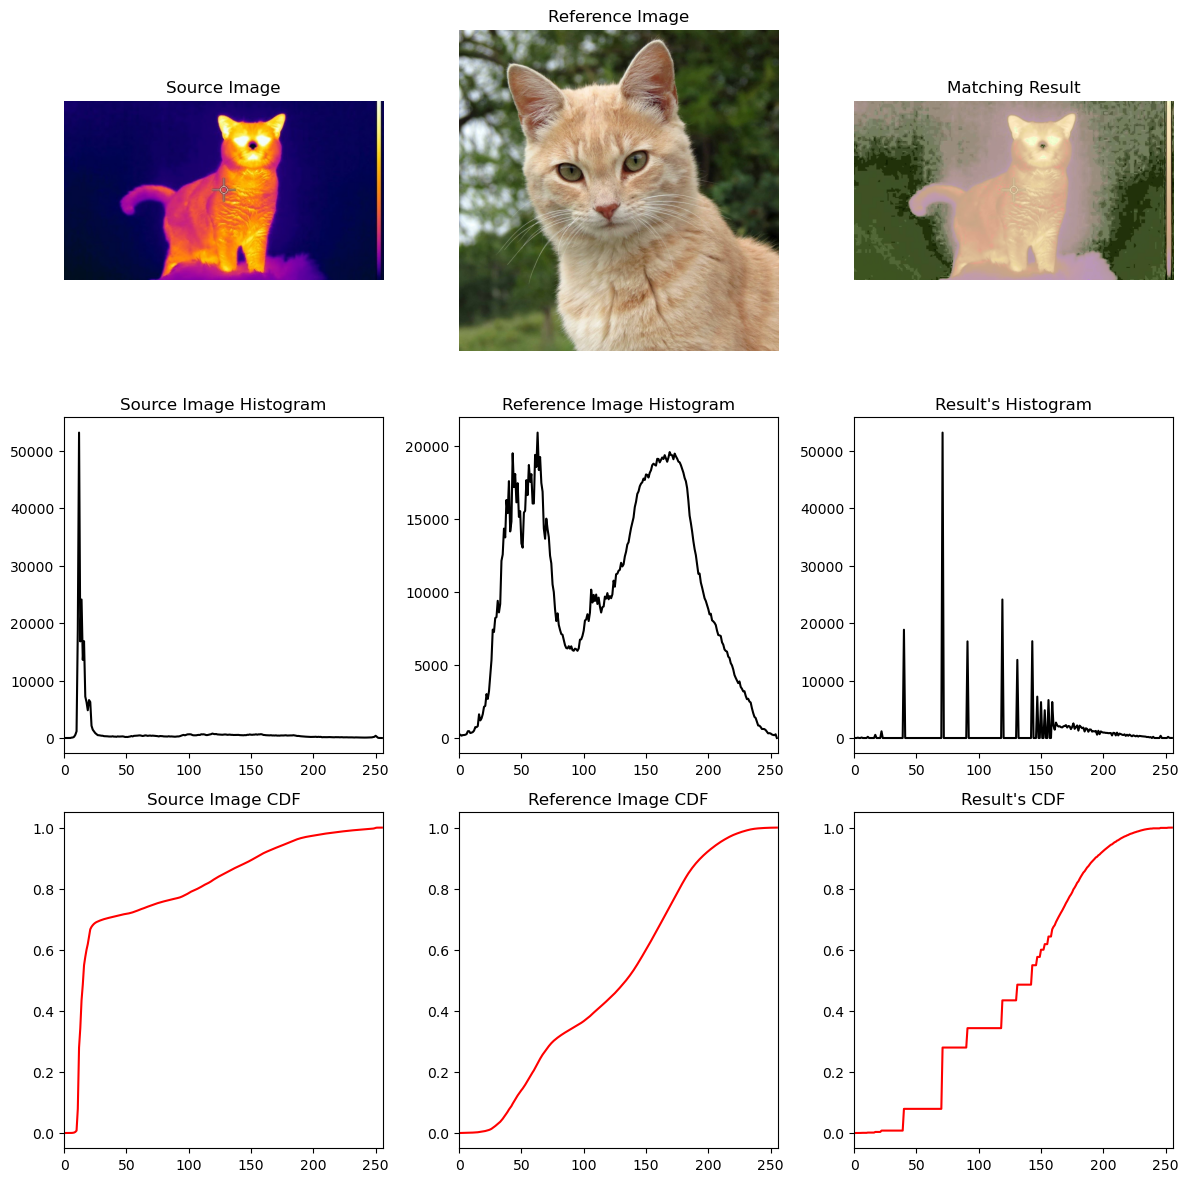

In [8]:
tircat_hismatch = cv2.imread(data_dir + "tir_cat.jpg")
cat_hismatch = cv2.imread(data_dir + "cat.jpg")

tir_cat = cv2.cvtColor(tircat_hismatch, cv2.COLOR_BGR2YCrCb)
cat_hismatch = cv2.cvtColor(cat_hismatch, cv2.COLOR_BGR2YCrCb)


matched_cat = match_histogram(tir_cat, cat_hismatch)
plot_results(tir_cat, cat_hismatch, matched_cat)

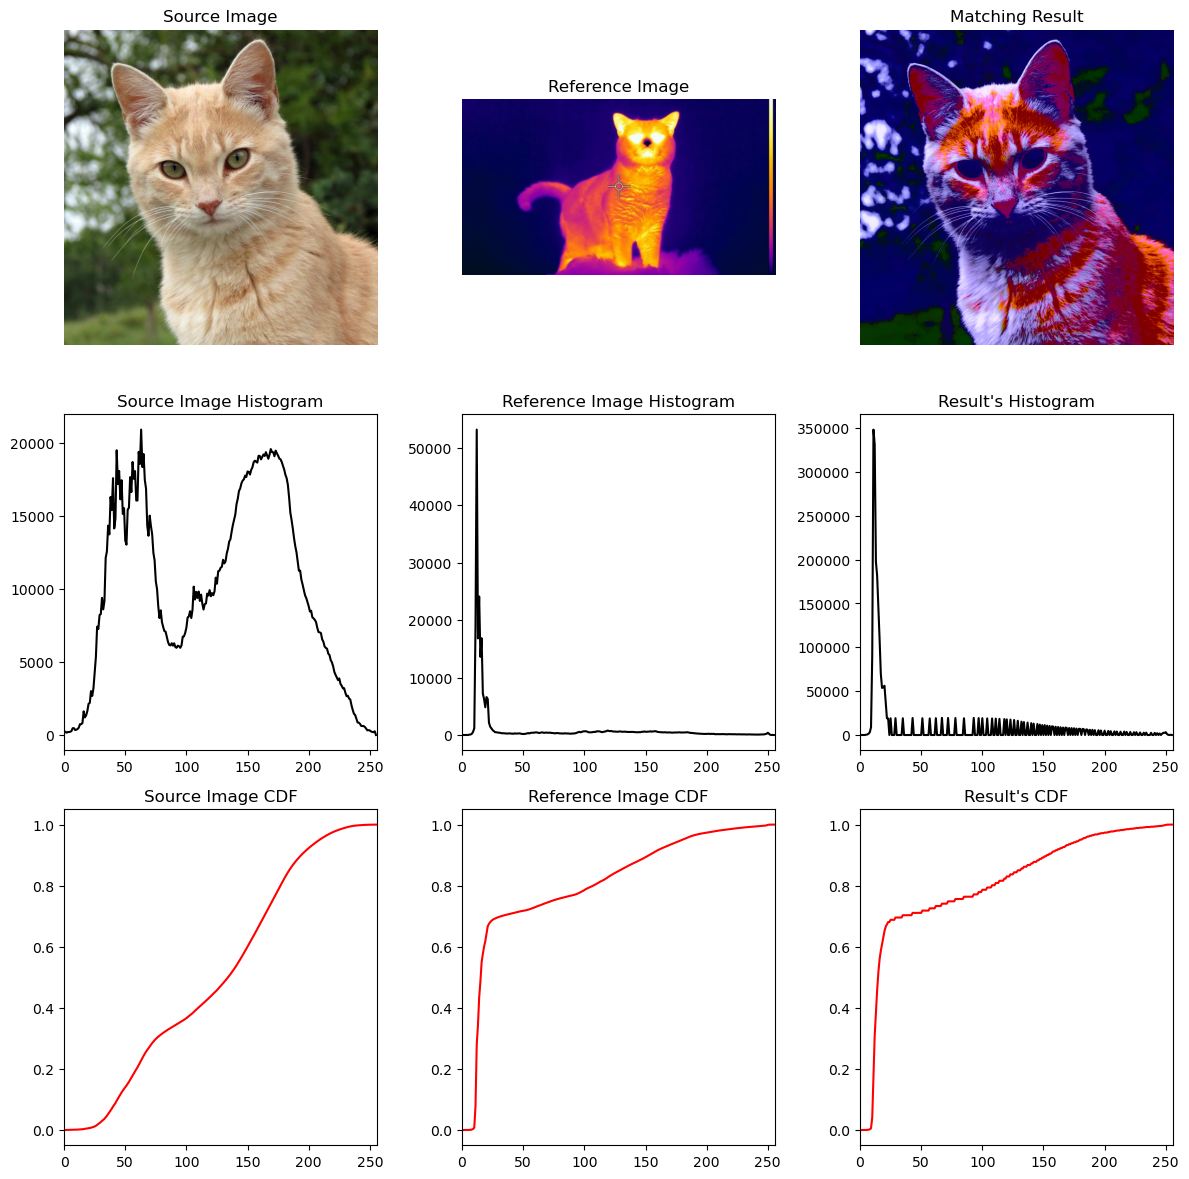

In [9]:
matched_cat_rev = match_histogram(cat_hismatch, tir_cat)
plot_results(cat_hismatch, tir_cat, matched_cat_rev)

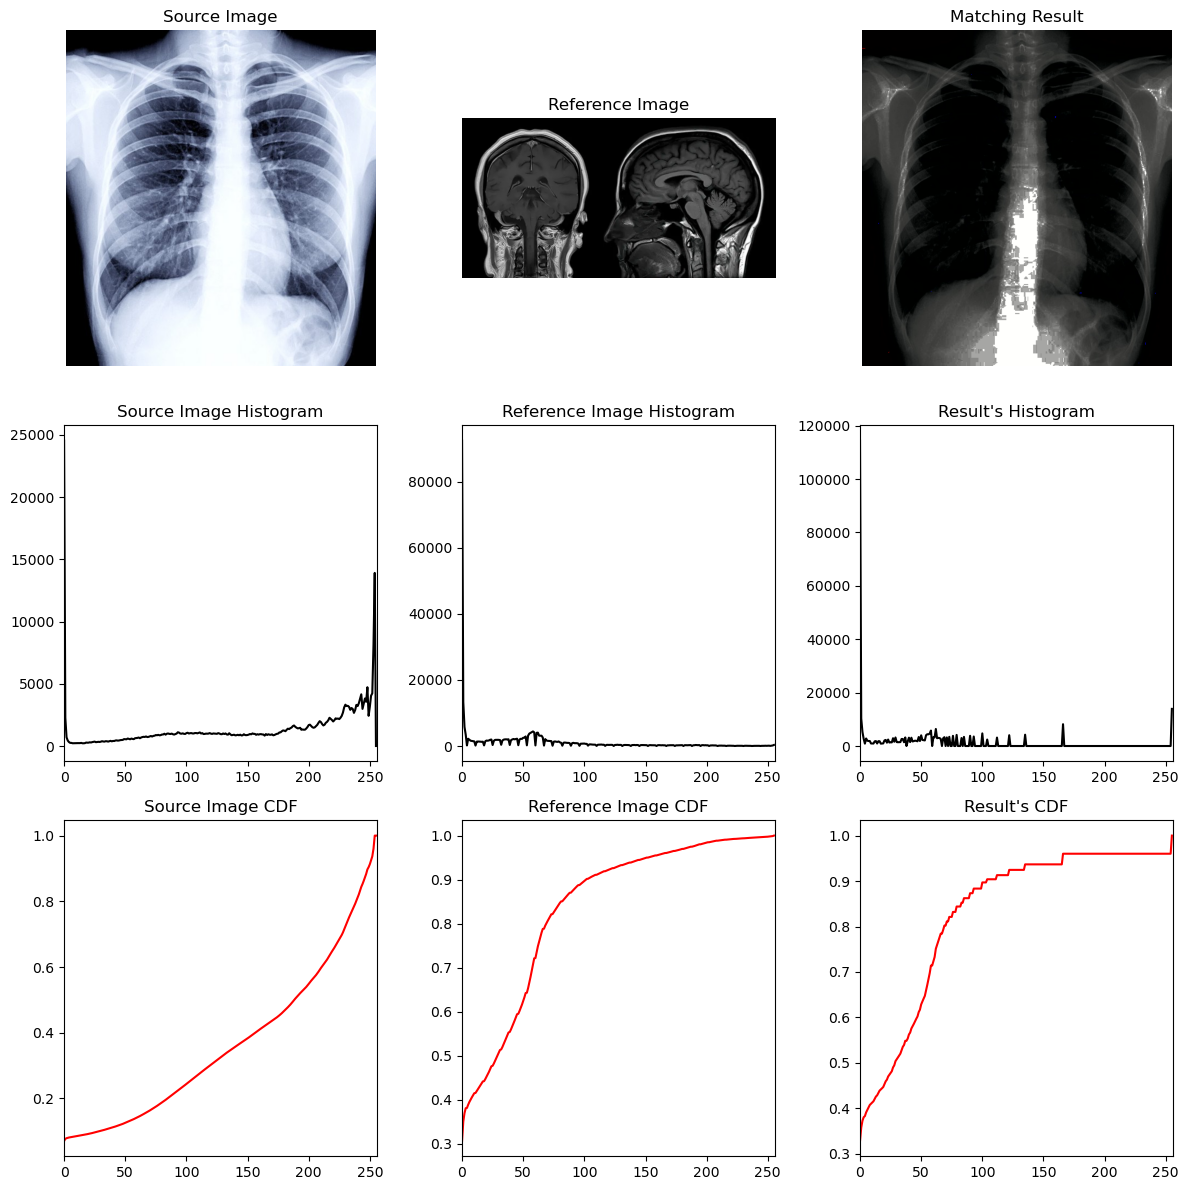

In [10]:
xray_hismatch = cv2.imread(data_dir + "xray_chest.jpg")
mri_hismatch = cv2.imread(data_dir + "mri_brain.jpg")

xray_hismatch = cv2.cvtColor(xray_hismatch, cv2.COLOR_BGR2YCrCb)
mri_hismatch = cv2.cvtColor(mri_hismatch, cv2.COLOR_BGR2YCrCb)


matched_med = match_histogram(xray_hismatch, mri_hismatch)
plot_results(xray_hismatch, mri_hismatch, matched_med)

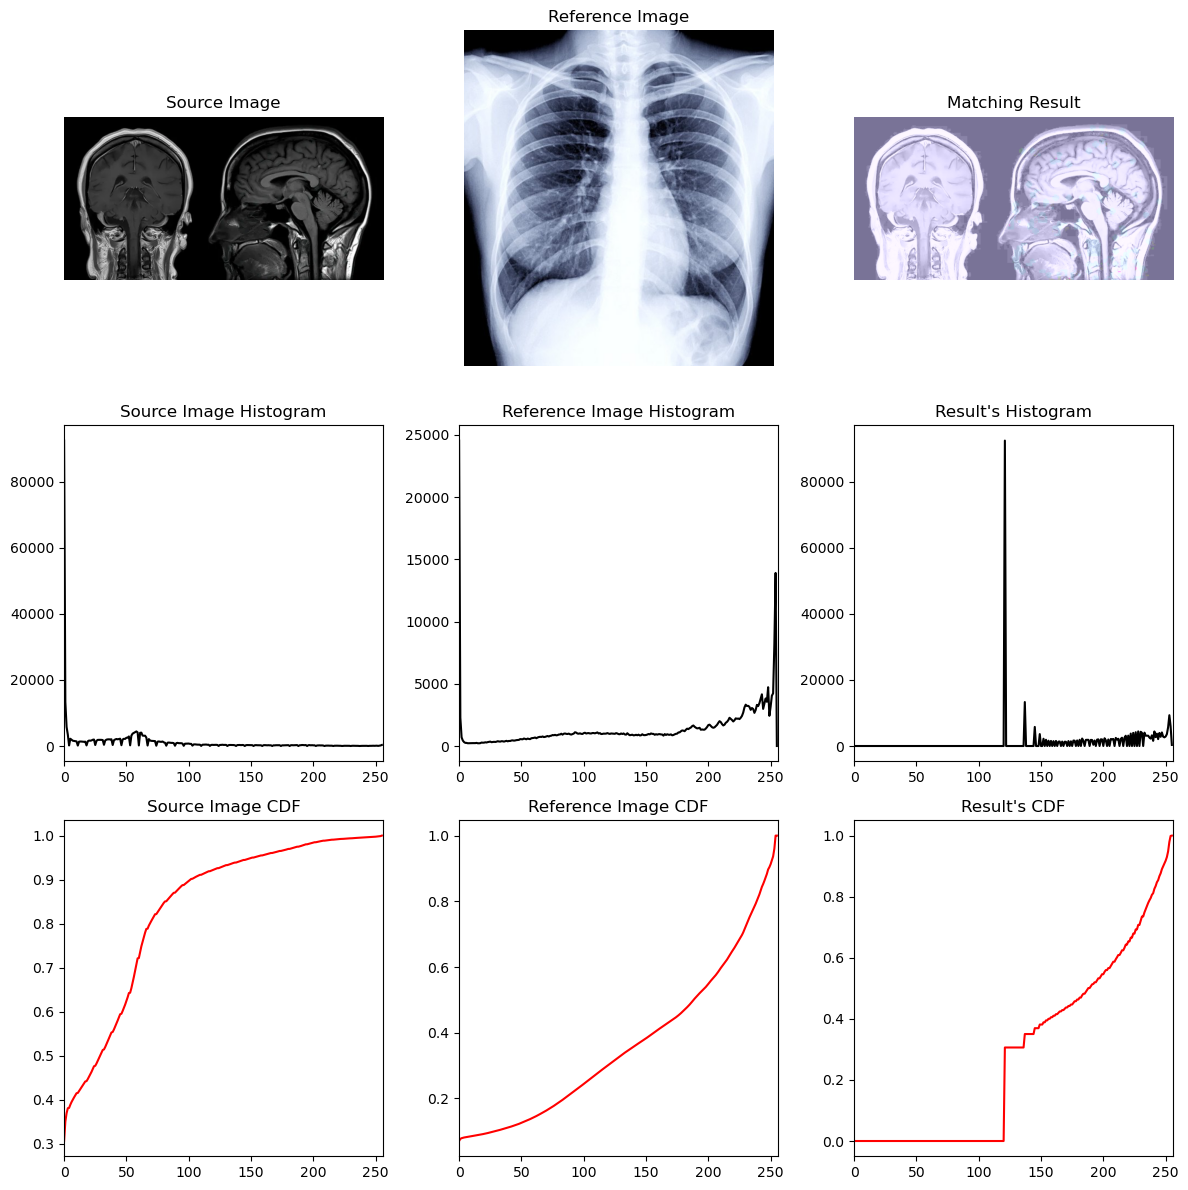

In [11]:
matched_med_rev = match_histogram(mri_hismatch, xray_hismatch)
plot_results(mri_hismatch, xray_hismatch, matched_med_rev)

## Evaluating the Effectiveness of Histogram Matching

#### Cases Where It Works Well:
1. **Color Landscape vs. Monotonous Landscape**
   - Matching helps the color image achieve a brightness distribution closer to the monotonous version, creating a reasonable transformation effect.
   - The histogram of the luminance channel (Y) aligns well with the reference image.
   
2. **Daytime vs. Nighttime Satellite Images**
   - Matching helps simulate brightness variations between images of the same type.
   - The result clearly reflects differences in illumination over time.

---

#### Cases Where It Performs Poorly:
1. **Thermal (TIR) Image vs. Regular Image**
   - Thermal images store data based on temperature rather than visible light.
   - Even though the histograms align, the transformed image has no meaningful visual interpretation.

2. **X-ray vs. MRI**
   - X-ray images represent X-ray absorption through dense tissue, while MRI shows signals from soft tissues.
   - Histogram Matching only adjusts brightness and cannot highlight the desired structures.

---

#### Reasons Why Histogram Matching May Fail:
- **Different Pixel Value Distributions by Nature**
  - Histogram Matching only modifies brightness distribution without altering the physical information in the image.

- **Structural Differences Between Images**
  - If two images have vastly different details and textures, matching cannot make them look similar in content.

- **Different Color Spaces**
  - Performing matching only on the Y (luminance) channel may not be sufficient to achieve the desired results.

---

#### Possible Improvements:
- Matching across **all color channels (RGB, Lab)** instead of just the Y channel.
- Applying **Histogram Equalization before Matching** to balance brightness distribution.
- Using **Deep Learning methods (GANs, Feature Mapping)** for domain adaptation when transforming between different types of images.

## Observations on CDF in Histogram Matching

#### CDF Behavior When Matching is Effective:
- When Histogram Matching works well, the CDF of the matched image closely aligns with the reference image’s CDF.
- The CDF curve is smooth, without noticeable discontinuities or stair-step patterns.
- This indicates that the brightness distribution has been adjusted effectively.

#### CDF Behavior When Matching is Ineffective:
- In cases where Matching is ineffective (e.g., thermal image vs. normal image, X-ray vs. MRI), the CDF of the matched image tends to show **disruptions** or **stair-step patterns**.
- These steps occur because the pixel distributions of the source and reference images differ too much, leading to non-uniform mapping.
- When pixel values cannot be perfectly aligned, interpolation results in sudden jumps in the CDF.

#### Causes of "Stair-Step" Effects in CDF:
- **Differences in Pixel Value Ranges:** If the dynamic range of pixel values is too different, mapping cannot be smooth.
- **Fundamental Differences in Brightness Distribution:** Thermal images are based on temperature variations, while regular images depend on reflected light. As a result, their CDFs cannot align perfectly.
- **Interpolation Limitations:** When histograms of two images are highly dissimilar, interpolation introduces abrupt transitions rather than a continuous CDF.

#### Conclusion:
- When Matching is effective, the matched image’s CDF will nearly align with the reference image.
- If two images have fundamentally different characteristics, Matching only adjusts overall brightness but cannot achieve a perfect transformation.
- The presence of stair-step patterns in the CDF is a sign of suboptimal or incompatible Matching.